# **Can you hear the size of a reservoir?**

**MOD510: Project 2**

Date: **September 13th 2025**

Names: **Malvin Varpe and Torgrim Odde**

**Learning objectives.** By completing this project, you will:

• Implement numerical solvers for the radial diffusivity equation.

• Use the solvers to compute pressure as a function of distance from a well,
both at steady-state conditions and for transient flow.

• For the steady-state case, compare the implemented model to an analytical
solution.

• Apply the time-dependent model to study pressure decline in a well, and
estimate the size of a reservoir from well test data.

• Investigate time efficiencies of sparse versus dense matrix solvers.

**Abstract**

This project investigates the radial fluid in a porous reservoir by solving the pressure-diffusivity equation in logarithmic space. Both steady-state and transient solutions were used using finite-difference discretization and solved via the Thomas algorithm for tridiagonal systems. The model successfully reproduced the expected physical behavior (a logarithmic pressure decline near the well and stabilixation at late times as the outer boundaries are reached).
Comparison between the analytical and numerical results showed a second-order spatial accuracy at interior points, and  first-order accuracy at the boundaries. A well test data set was used to calibrate the model by adjusting the paramaters k (permeability), pi (initial pressure) and re (reservoir radius). The fitted parameters were able to produce the bottomhole pressure curve with high accuracy, and the resulting reservoir pore volume was estimated to 2.4*10^5 m^3. The project demonstrates that by implementing the finite-different solver is an accurate procedure for modeling pressure transients and interpreting well data.

**Introduction**

In petroleum engineering, it is important to predict and iterpret the pressure behavior near production wells to estimate permeability, reservoir size and fluid storage. When a well is opened for outward flow, a pressure disturbance spreads through the reservoir formation. The dynamics of this pressure over time and distance is estimated with the diffusitivity equation, a partial differential equation that pairs fluid flow with rock and fluid compressability.

This project adresses the numerical and analytical solutions of this diffusitivity equation under cylindrical symmetry. The goal of this project is split into 3;
1. Derive and verify the finite-difference approximation for steady-state and transien flow in a reservoir.
2. Investigate numerical accuracy through comparison with analytical line-source and steady-state equations.
3. Use the model to simulate real-life test conditions and fit the model to measure bottomhole pressure data using known key reservoir parameters.

We are going to explore spatial discretization, boundary conditions (lazy vs not-so-lazy), and paramter sensitivity on the simulated pressure response.

***  
# Exercise 1 - Steady-state solution  

The simplest situation is when there is no pressure-variation in time, i.e., steadystate
flow. Then, we can replace the partial derivatives with ordinary derivatives,
and equations (12), (13), and (14) become:  
$ d^2p/dy2 (y) = 0$ for all y  $(16)$    
$ dp/dy(y = y_w) = \ alpha $ $(17) $  
$ p(y = y_e) = p_{init}$  $ (18) $  

**Part 1**  
Show that the analytical solution to equations (16), (17), and (18) is  
$ p(y) = p_{init} +\alpha(y − y_e)$. $ (19)$

Given the second-order differential equation:

$$
\begin{aligned}
\frac{d^2 p}{dy^2} &= 0 \\[6pt]
\frac{dp}{dy} &= \int 0\, dy = C_1
\end{aligned}
$$


By using $\frac{dp}{dy}(y = y_w) = \alpha$, we get $ C_1 = \alpha$. Further we have:


$$
p(y) = \int \alpha \, dy = \alpha \cdot y + C_2
$$

By using $p(y = y_e) = p_{\text{init}}$ we get:


$$
\begin{align}
p(y=y_e) = \alpha \cdot y_e + C_2 &= p_{\text{init}}  \\
C_2 &= p_{\text{init}}-\alpha \cdot y_e
\end{align}
$$
Which in turn gives the equation for $p(y)$:
$$
p(y)=\alpha \cdot y + p_{\text{init}} -\alpha \cdot y_e=p_{\text{init}}+\alpha (y-y_e)
$$  
  

  

**Part 2**  
To enforce a fixed pressure $p_e = p(y_e) = p_{init}$ at the edge of the reservoir, the "lazy" option for the exterior reservoir boundary is to simply set  
$ p_N = p_e $  $(20)$
Let $N = 4$. When using the "lazy" implementation of the boundary condition at $y = y_e$, derive the following matrix equation, starting from the general finite difference equations for any $N$.

We start with the assumption that the second derivative of pressure with respect to $y$ is zero:

$$
\frac{d^2p}{dy^2} = 0
$$

To solve this numerically, we approximate the second derivative using a central difference scheme, or equation 3.13 in the book. Each node is separated by a $ \Delta y$. Approximating the error term to be zero gives:

$$
\frac{d^2p}{dy^2} = \frac{p_{i+1} + p_{i-1} - 2p_i }{\Delta y^2} + \frac {(\Delta y)^2}{12} f^{(4)}( \eta ) \approx \frac{p_{i+1} + p_{i-1} - 2p_i }{\Delta y^2}
$$

We can find solutions for the ghost nodes. We have the boundrary value at the distance $y_w$, which lies in the middle between node $p_0$ and $p_{-1},$ but since we have a linear function the derivative is the same for all y. 


$$
\frac{dp}{dy} = \frac{p_0 - p_{-1}}{\Delta y} + \mathcal{O}((\Delta y)^2) =\alpha
$$

Here $ \mathcal{O}((\Delta y)^2) $ represents the truncation error of second order, and by approximating this to be zero(which it is for linear functions) we get that we can express the ghost node as $ p_{-1} = p_0-\Delta y \alpha $  
We can then get the general equation at the boundary nodes, interior nodes and at node $N-1$, if $N$ is number of nodes. We already have a "lazy" solution that approximates $ p_N = p_e $.


1. ***At node 0:***
   $$
   \begin{align}
   \left.\frac{d^2p}{dy^2}\right|_{i=0} \approx \frac{p_1 - p_{-1}-2\cdot p_0}{(\Delta y)^2} = \frac{ p_1+(p_0-2h \alpha ) -2p_0}{(\Delta y)^2}&=0 \\
   -p_0 +p_1 &= \alpha \Delta y
   \end{align}
   $$

2. ***At interior node $ i $:***
   $$
   \begin{align}
   \frac{d^2p}{dy^2} \approx \frac{p_{i+1} - 2p_i + p_{i-1}}{(\Delta y)^2} &= 0 \\
   p_{i-1} - 2p_i + p_{i+1} &= 0
   \end{align}
   $$

3. ***At node $ N -1 $ :***
   \begin{align}
   \frac{d^2p}{dy^2} \approx \frac{p_{N} + p_{N-2}-2p_{N-1}}{(\Delta y)^2} &= 0 \\
   p_{N-2}-2p_{N-1} &= -p_e
   \end{align}

For the four nodes one can write this as a matrix equation like this:
$$
\begin{pmatrix}
-1 & 1 & 0 & 0 \\
1 & -2 & 1 & 0 \\
0 & 1 & -2 & 1 \\
0 & 0 & 1 & -2
\end{pmatrix}
\begin{pmatrix}
p_0 \\
p_1 \\
p_2 \\
p_3
\end{pmatrix}
=
\begin{pmatrix}
\alpha \Delta y \\
0 \\
0 \\
- p_e
\end{pmatrix}
$$
  

**Part 3** 
What is the truncation error for the finite difference approximation at interior grid points? (be as specific as you can!)

The truncation error for each of the interior nodes are given in equation 3.13, and is $ \epsilon = \frac {(\Delta y)^2}{12} f^{(4)}( \eta )$, where $ \eta $ is in the interval $ [y_i,y_i+\Delta y] $. This means that the error term is proportional to the distance between the nodes squared ($(\Delta y)^2$).  
In the case of this steady state, we have a smooth linear function where $ \frac{d^2p}{dy^2} = 0 $, which in turn would give $ f^{(4)}(y)=0 $. Therefore, the error term for the interior nodes are $0$. 

**Part 4**
We want to investigate, theoretically, the error of the "lazy" approximation to the pressure boundary condition. Use Taylor’s formula to:  
• Find how the order of the numerical error scales when using the "lazy" approximation.

We let interior nodes indices be $ (0,1,2,...,N-1) $, where the last interior node is $ i = N-1$ , the ghost node is $ N $.  

With that, we can use

$$
p_e \equiv p(y_e) \approx \tfrac12 \bigl( p_{N-1} + p_N \bigr)
$$

if the solution is locally linear/midpoint average.  
The lazy implementation sets the ghost/node value

$$
p_N = p_e.
$$

By comparing these two, we can derive that the exact ghost value (from Taylor series) is

$$
p_N^{(\mathrm{true})} \approx 2 p_e - p_{N-1}, \qquad
p_N^{(\mathrm{lazy})} = p_e.
$$

The difference is thus

$$
p_N^{(\mathrm{lazy})} - p_N^{(\mathrm{true})}
= p_e - \bigl( 2 p_e - p_{N-1} \bigr)
= p_{N-1} - p_e.
$$

By Taylor expanding  $p_e$  about  $y_{N-1}$  we get

$$
p_e = p_{N-1} 
+ \frac{\Delta y}{2} p'_{N-1} 
+ \frac{(\Delta y)^2}{8} p''_{N-1} 
+ \dots
$$

so

$$
p_{N-1} - p_e
= -\frac{\Delta y}{2} p'_{N-1} + \mathcal{O}(\Delta y^2).
$$

Therefore, the lazy ghost error is in general  $\mathcal{O}(\Delta y)$  (first order).

---

• Use Taylor’s formula to show that we can derive the following, "not-so-lazy" version of the boundary condition:

$$
p_N = 2 p_e - p_{N-1}.
$$

Assuming the physical boundary $y_e$ is located half way between grid points $y_{N-1}$ and $y_N$;  
If $p$ is linear or smooth in the local interval, then:

$$
p_e = \frac{p_{N-1} + p_N}{2}.
$$

Solving for $ p_N $ yields

$$
p_N = 2 p_e - p_{N-1}.
$$

This is the standard linear extrapolation relation for a Dirichlet value placed at the midpoint of the last cell.  
It enforces that the nodal values and the boundary value lie on a straight line (so that it is consistent with the second-order accuracy). A Taylor series expansion around $ y_{N-1} $ shows the error in this relation is $\mathcal{O}(\Delta y^2)$, so it is second-order accurate.

---

• Let $ N = 4 $. What is the matrix equation we now need to solve when using equation $(22)$ for the outer boundary condition?

Using the same indexing convention as previous: unknown nodal pressures are  
$$
(p_0, p_1, p_2, p_3)
$$
and there is a ghost $ p_4 $.

The finite-difference interior equations are:

$$
\frac{p_{i+1} - 2p_i + p_{i-1}}{\Delta y^2} = 0, \qquad i = 1,2.
$$

For $ i = 0 $ we can use the forward difference:

$$
\frac{p_1 - p_0}{\Delta y} = \alpha
\quad\Rightarrow\quad
 -p_0 + p_1 = \alpha \Delta y.
$$

For the last interior node $ i = 3 $, the Laplace would be:

$$
\frac{p_4 - 2p_3 + p_2}{\Delta y^2} = 0
\quad\Rightarrow\quad
p_2 - 2p_3 + p_4 = 0.
$$

Substituting the not-so-lazy ghost formula $p_4 = 2p_e - p_3$ to eliminate $p_4$:

$$
p_2 - 2p_3 + (2p_e - p_3) = 0
\quad\Rightarrow\quad
p_2 - 3p_3 + 2p_e = 0.
$$

The linear equations are therefore:

$$
\begin{aligned}
\text{Neumann at left:} \quad & -p_0 + p_1 + 0 p_2 + 0 p_3 = \alpha \Delta y \\
\text{interior } i=1: \quad & p_0 - 2 p_1 + p_2 + 0 p_3 = 0 \\
\text{interior } i=2: \quad & 0 p_0 + p_1 - 2 p_2 + p_3 = 0 \\
\text{last node:} \quad & 0 p_0 + 0 p_1 + p_2 - 3 p_3 = - 2 p_e
\end{aligned}
$$

Written in matrix form this can be represented as $A p = b$, with

$$
p =
\begin{bmatrix}
p_0 \\ p_1 \\ p_2 \\ p_3
\end{bmatrix}.
$$

$$
A =
\begin{pmatrix}
-1 & 1 & 0 & 0 \\
1 & -2 & 1 & 0 \\
0 & 1 & -2 & 1 \\
0 & 0 & 1 & -3
\end{pmatrix}
\qquad
b =
\begin{pmatrix}
\alpha \Delta y \\
0 \\
0 \\
- 2p_e
\end{pmatrix}.
$$


**Part 5**

• For both implementations of the boundary condition at $y = y_e$, solve the
matrix equation multiple times by varying the number of grid points.  

• Based on your simulation results, make a scatter plot of the numerical
error versus grid size. Ideally, you should evaluate the different solutions
at the same physical point in space. Use the analytical formula given by
equation $(19)$ as the "true solution".



The Thomas algorithm is feasible for solving the steady-state system because the discretized equations for interior nodes take the form $ a_i p_{i-1} + c_i p_{i+1} = b_i p_i $, which can be rearranged as $ a_i p_{i-1} + c_i p_{i+1} - b_i p_i = 0 $. This structure leads to a tridiagonal matrix, where each equation only involves the current node and its immediate neighbors. The Thomas algorithm efficiently solves such systems in linear time, making it well-suited for problems where $ |a_i| + |c_i| \leq |b_i| $ and the matrix remains diagonally dominant and stable [[Hiorth, 2024]](#hiorth). In our case we have this fulfilled.  

In [2]:
import numba as nb
import numpy as np

@nb.jit(nopython=True)
def thomas_algorithm(l, d, u, r):
    """
    Solves a tridiagonal linear system of equations using the Thomas algorithm.

    Based on the pseudo-code from:
    Cheney, E. W., & Kincaid, D. R.
    Numerical Mathematics and Computing, 7th edition,
    Cengage Learning, 2013.

    IMPORTANT NOTES:
    - This function modifies the contents of the input vectors l, d, u, and r.
    - For Numba to work properly, all inputs must be NumPy arrays (not lists).

    Parameters:
        l (np.ndarray): Lower diagonal (l[0] is unused).
        d (np.ndarray): Main diagonal.
        u (np.ndarray): Upper diagonal (u[-1] is unused).
        r (np.ndarray): Right-hand side vector.

    Returns:
        np.ndarray: Solution vector.
    """
    # Allocate memory for solution
    solution = np.zeros_like(d)
    n = len(solution)

    # Forward elimination
    for k in range(1, n):
        xmult = l[k] / d[k - 1]
        d[k] = d[k] - xmult * u[k - 1]
        r[k] = r[k] - xmult * r[k - 1]

    # Back-substitution
    solution[n - 1] = r[n - 1] / d[n - 1]
    for k in range(n - 2, -1, -1):
        solution[k] = (r[k] - u[k] * solution[k + 1]) / d[k]

    return solution

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

class PressureSolver:
    """
    A finite difference solver to compute pressure distribution in a reservoir.
    A logarithmic grid is used, where y = ln(r/rw).

    The solver uses SI units internally, while "practical field units"
    are required as input.

    Input arguments:
        name        symbol      unit
        -----------------------------------------------
        N           N           dimensionless
        dt          dt          days
        rw          rw          ft
        re          re          ft
        h           h           ft
        k           k           mD
        phi         phi         dimensionless
        mu          mu          mPas (cP)
        ct          ct          1 / psi
        Q           Q           bbl / day
        pi          pi          psi
        -----------------------------------------------
    """

    def __init__(self,
                 N,
                 dt,
                 n_steps=100,
                 rw=0.318,
                 re=1000.0,
                 h=11.0,
                 phi=0.25,
                 mu=1.0,
                 ct=7.8e-6,
                 Q=1000.0,
                 k=500,
                 pi=4100.0,
                 lazy=False,
                 alpha_simple=False):
        # Unit conversion factors (input units → SI)
        self.ft_to_m_ = 0.3048
        self.psi_to_pa_ = 6894.75729
        self.day_to_sec_ = 24.0 * 60.0 * 60.0
        self.bbl_to_m3_ = 0.1589873

        # Grid
        self.N_ = N
        self.rw_ = rw * self.ft_to_m_
        self.re_ = re * self.ft_to_m_
        self.h_ = h * self.ft_to_m_
        self.ye_ = self.calculate_y(self.re_)
        self.yw_ = self.calculate_y(self.rw_)
        self.dy_ = (self.ye_-self.yw_)/(self.N_)
        self.y_values_, self.r_values_ = self.grid_values(n=self.N_)


        # Rock and fluid properties
        self.k_ = k * 1e-15 / 1.01325  # from mD to m² (adjusted for atmospheric pressure)
        self.phi_ = phi
        self.mu_ = mu * 1e-3  # from cP to Pa·s
        self.ct_ = ct / self.psi_to_pa_
        self.eta_ = self.k_ / (self.phi_ * self.mu_ * self.ct_)

        # Initial and boundary conditions
        self.Q_ = Q * self.bbl_to_m3_ / self.day_to_sec_
        self.pi_ = pi * self.psi_to_pa_

        # Time control for simulation
        self.dt_ = dt * self.day_to_sec_

        # TO DO: Add more attributes (grid coordinates, dy, eta, etc.)
        # Creating variables depending on input for alpha and lazy solution.     
        #    
        self.lazy = lazy
        if alpha_simple:
            self.alpha_ = 1.0
        else:
            self.alpha_ = (self.Q_ * self.mu_) / (2 * np.pi * self.k_ * self.h_)
        



        
        self.rhs = self.setup_rhs_steady_state()
        self.A = self.build_tridiagonal_matrix(*self.steady_state_diagonals())
        self.solved_steady = self.solve_steady_state()

        if dt > 0:
            self.n_steps_ = n_steps
            self.A_time = self.build_tridiagonal_matrix(*self.diagonals_time_dependent())



    def build_tridiagonal_matrix(self, lower, main, upper):
        """
        Constructs a full tridiagonal matrix from its diagonals.

        Parameters:
            lower (np.ndarray): Lower diagonal (length N).
            main (np.ndarray): Main diagonal (length N).
            upper (np.ndarray): Upper diagonal (length N).

        Returns:
            np.ndarray: Full (N x N) tridiagonal matrix.
        """
        N = len(main)
        mat = np.zeros((N, N))
        np.fill_diagonal(mat, main)
        np.fill_diagonal(mat[1:], lower[1:])
        np.fill_diagonal(mat[:,1:], upper[:-1])
        return mat

    def calculate_y(self,r_val):
        """ 
        Calculates the logarithmic grid coordinate y = ln(r_val/rw)
        """
        return np.log(r_val/self.rw_)
    
    def calculate_r(self,y_val):
        """ 
        Calculates the radial grid coordinate r = rw * exp(y_val)
        """
        return self.rw_ * np.exp(y_val)
    
    def grid_values(self, n):
        """ 
        Returns the y and r values for the grid points
        """
        y_values = np.linspace(self.yw_+self.dy_/2, self.ye_-self.dy_/2, n)
        r_values = self.calculate_r(y_values)

        return y_values, r_values
    


    def setup_rhs_steady_state(self):

        """
        Creates the RHS vector for steady-state pressure calculation. Depends on boundary conditions.

        Returns:
            np.ndarray: RHS vector.
        """
        rhs = np.zeros(self.N_)
        rhs[0] = self.alpha_ * self.dy_

        if self.lazy:
            rhs[-1] = -self.pi_

        else:
            rhs[-1] = -2*self.pi_ 

        return rhs
    

            

    def steady_state_diagonals(self):
        """
        Constructs the lower, main, and upper diagonals for the tridiagonal matrix
        used in the finite difference discretization of the steady-state pressure equation.

        Returns:
            tuple: (lower, main, upper) diagonals as numpy arrays.
        """

        lower = np.ones(self.N_)*1
        upper = np.ones(self.N_)*1
        main = np.ones(self.N_)*-2
        lower[0] = upper[-1] = 0
        main[0] = -1
        if self.lazy:
            main[-1] = -2
        else:
            main[-1] = -3
        return lower, main, upper
            
    def solve_steady_state(self):
 
        """
        Solves the steady-state pressure distribution, using Thomas Algorithm(Fastest computation for tridiagonal systems).

        Returns:
            np.ndarray: Pressure values.
        """
        
        solved = thomas_algorithm(*self.steady_state_diagonals(), self.rhs)

        return solved


    def solution_steady(self, y_vals):
        """ 
        Analytical solution for steady state, for given y values.
        """

        return self.pi_ + self.alpha_ * (y_vals - self.ye_)

    
    
    def analytical_steady_state(self):
        """ 
        Analytical solution for steady state, for the y_values that we have in the grid.
        """

        return self.pi_ + self.alpha_ * (self.y_values_ - self.ye_)

    
    def steady_run_errors(self):

        """
        Computes the L2 norm and pointwise error of the steady-state numerical solution
        compared to the analytical solution.

        Returns:
            tuple: (err_L2, err_pt)
            err_L2 (float): L2 norm of the error over all grid points, i.e average error.
            err_pt (float): Pointwise error at r = sqrt(rw * re).
        """

        err_L2 = np.linalg.norm(self.solved_steady - self.analytical_steady_state()) / np.sqrt(self.N_)
        # pointwise error at fixed physical radius
        r_star = np.sqrt(self.rw_ * self.re_)
        p_num_star = np.interp(r_star, self.r_values_, self.solved_steady)
        p_ana_star = np.interp(r_star, self.r_values_, self.analytical_steady_state())
        err_pt = abs(p_num_star - p_ana_star)
        return err_L2, err_pt


    
    def plot_steady_state(self, ax=None, xlim = None):
        """
        Plots the numerical and analytical steady-state pressure distribution.

        Parameters:
        ax (matplotlib.axes.Axes, optional): Axis to plot on. If None, creates a new figure.
        """
        local_fig = None
        if ax is None:
            local_fig, ax = plt.subplots(figsize=(6, 4))

        # Adding both plots
        ax.plot(self.r_values_, self.solved_steady, label='numerical')
        ax.plot(self.r_values_, self.analytical_steady_state(), '--', label='analytical')
        ax.legend()

        ax.set_xlabel('r [m]')
        ax.set_ylabel('Pressure [Pa]')
        ax.set_xbound(xlim)
        ax.set_title(f'N = {self.N_}')
        ax.grid(True)
        
        if local_fig is not None:
            plt.tight_layout()
            plt.show()
       


    # --------------------------------------
    # Time dependent solution
    # --------------------------------------
    
    def xi_i(self, i):
        """
        Calculates ξi ≡ ηe^{-2yi}Δt / (rw^2 Δy^2)
        where:
            η = (k*h)/(phi*mu*ct)
            yi = grid coordinate at index i
            Δt = time step (seconds)
            rw = well radius (meters)
            Δy = grid spacing
        """
        
        yi = self.y_values_[i]
        numerator = self.eta_ * np.exp(-2 * yi) * self.dt_
        denominator = (self.rw_ ** 2) * (self.dy_ ** 2)
        return numerator / denominator

    def beta(self):
        """
        Calculates β ≡ QμΔy / (2πkh)
        where:
            Q = volumetric flow rate (m^3/)
            μ = viscosity (Pa·s)
            Δy = grid spacing
            k = permeability (m^2)
            h = reservoir thickness (m)
        """
        return (self.Q_ * self.mu_ * self.dy_) / (2 * np.pi * self.k_ * self.h_)
    
    def diagonals_time_dependent(self):
        """
        Constructs the lower, main, and upper diagonals for the tridiagonal matrix
        used in the finite difference discretization of the time-dependent pressure equation.

        Returns:
            tuple: (lower, main, upper) diagonals as numpy arrays.
        """
        lower = upper = np.array([-self.xi_i(i) for i in range(self.N_)])
        main = np.array([1 + 2 * self.xi_i(i) for i in range(self.N_)])

        
        main[0] = 1 + self.xi_i(0)
        main[-1] = 1 + 3 * self.xi_i(self.N_-1)

        return lower, main, upper

    
    def rhs_time_dependent(self, previous_pressure):
        """
        Constructs the right-hand side (RHS) vector for the time-dependent pressure equation.

        Parameters:
            previous_pressure (np.ndarray): Pressure values from the previous time step.

        Returns:
            np.ndarray: RHS vector for the current time step.
        """
        rhs = previous_pressure.copy()
        rhs[0] = previous_pressure[0] - self.beta() * self.xi_i(0)
        rhs[-1] = previous_pressure[-1] + 2 * self.pi_ * self.xi_i(self.N_-1)

        return rhs

    def solve_time_dependent(self, solver = 'thomas'):
        """
        Solves the time-dependent pressure distribution in the reservoir using a finite difference scheme.

        Parameters:
            solver (str): The linear solver to use for each time step.
            - 'thomas': Uses the Thomas algorithm for tridiagonal systems.
            - 'numpy': Uses NumPy' general linear solver.
            - 'scipy': Uses SciPy' sparse solver for tridiagonal matrices.

        Returns:
            np.ndarray: Array of pressure values for each time step and grid point,
                shape (n_steps, N).
        """
        pressures = np.zeros((self.n_steps_, self.N_))
        pressures[0].fill(self.pi_) # Uniform initial pressure
        lower, main, upper = self.diagonals_time_dependent()

        diagonals_sparse = [upper[:-1], main, lower[1:]]  # Order matters!
        offsets = [1, 0, -1]
        A_sparse = sp.diags(diagonals_sparse, offsets, format='csc', shape=(self.N_, self.N_))

        if solver == 'thomas':
            for t in range(1, self.n_steps_):
                rhs = self.rhs_time_dependent(pressures[t-1])
                pressures[t] = thomas_algorithm(lower.copy(), main.copy(), upper.copy(), rhs) #Because the function modifies the arrays, need to copy them.

        elif solver == 'numpy':
            for t in range(1, self.n_steps_):
                rhs = self.rhs_time_dependent(pressures[t-1])
                pressures[t] = np.linalg.solve(self.A_time, rhs)

        elif solver == 'scipy':
            for t in range(1, self.n_steps_):
                rhs = self.rhs_time_dependent(pressures[t-1])
                pressures[t] = spsolve(A_sparse, rhs)

        return pressures
        

slope lazy ≈ -1.00, slope not-so-lazy ≈ 0.09


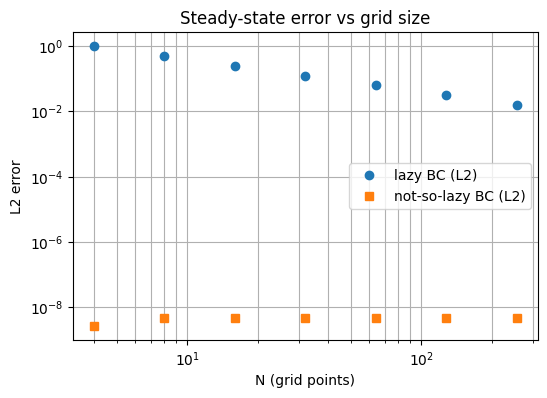

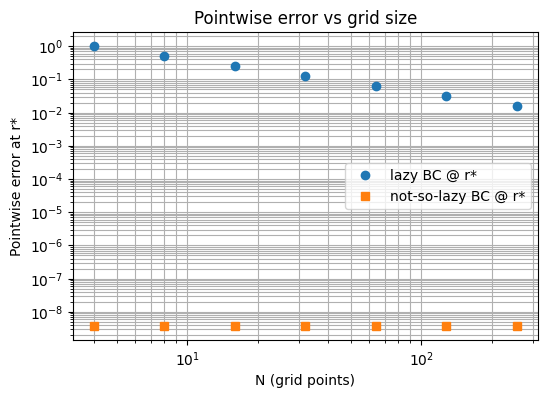

In [4]:
def convergence_study():
    """
    Perform a convergence study for the steady-state finite difference solver.

    Runs the solver for a range of grid sizes (Ns) using both "lazy" and "not-so-lazy" boundary conditions.
    Computes the L2 norm and pointwise errors for each case, and plots error versus grid size on log-log axes.
    Also prints the slope of the error decay for both boundary conditions.
    
    """
    Ns = [4, 8, 16, 32, 64, 128, 256]
    errs_lazy_L2, errs_nsl_L2 = [], []
    errs_lazy_pt, errs_nsl_pt = [], []

    for N in Ns:
        eL2, ept = PressureSolver(N, dt=0, lazy=True, alpha_simple=True).steady_run_errors()
        errs_lazy_L2.append(eL2)
        errs_lazy_pt.append(ept)
        eL2, ept = PressureSolver(N, dt=0, lazy=False, alpha_simple=True).steady_run_errors()
        errs_nsl_L2.append(eL2)
        errs_nsl_pt.append(ept)

    # Slopes (log–log)
    sl_lazy = np.polyfit(np.log(Ns), np.log(errs_lazy_L2), 1)[0]
    sl_nsl  = np.polyfit(np.log(Ns), np.log(np.maximum(errs_nsl_L2, 1e-30)), 1)[0]
    print(f"slope lazy ≈ {sl_lazy:.2f}, slope not-so-lazy ≈ {sl_nsl:.2f}")

    plt.figure(figsize=(6,4))
    plt.loglog(Ns, errs_lazy_L2, 'o', label='lazy BC (L2)')
    plt.loglog(Ns, errs_nsl_L2, 's', label='not-so-lazy BC (L2)')
    plt.xlabel('N (grid points)')
    plt.ylabel('L2 error')
    plt.title('Steady-state error vs grid size')
    plt.grid(True, which='both')
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.loglog(Ns, errs_lazy_pt, 'o', label='lazy BC @ r*')
    plt.loglog(Ns, errs_nsl_pt, 's', label='not-so-lazy BC @ r*')
    plt.xlabel('N (grid points)')
    plt.ylabel('Pointwise error at r*')
    plt.title('Pointwise error vs grid size')
    plt.grid(True, which='both')
    plt.legend()
    plt.show()
convergence_study()

From the graph, we can see the lazy BC shows a first-order decay of the error with grid refinement. This is consistent with the $\mathcal{O}(\Delta y)$ truncation.
With the not-so-lazy midpoint boundary, the steady solution is linear in $y$, so the numerical error is at round-off level and independent of $N$.

We solved the steady-state pressure equation for multiple grid resolutions ($N$) using both the lazy and the not-so-lazy boundary conditions at $y=y_e$ to assess overall convergence behavior. The analytical solution (equation 19) was evaluated at the same physical radius ($r=\sqrt{(r_w \cdot r_e)}$) for all grid sizes ensuring consistent error comparison. 

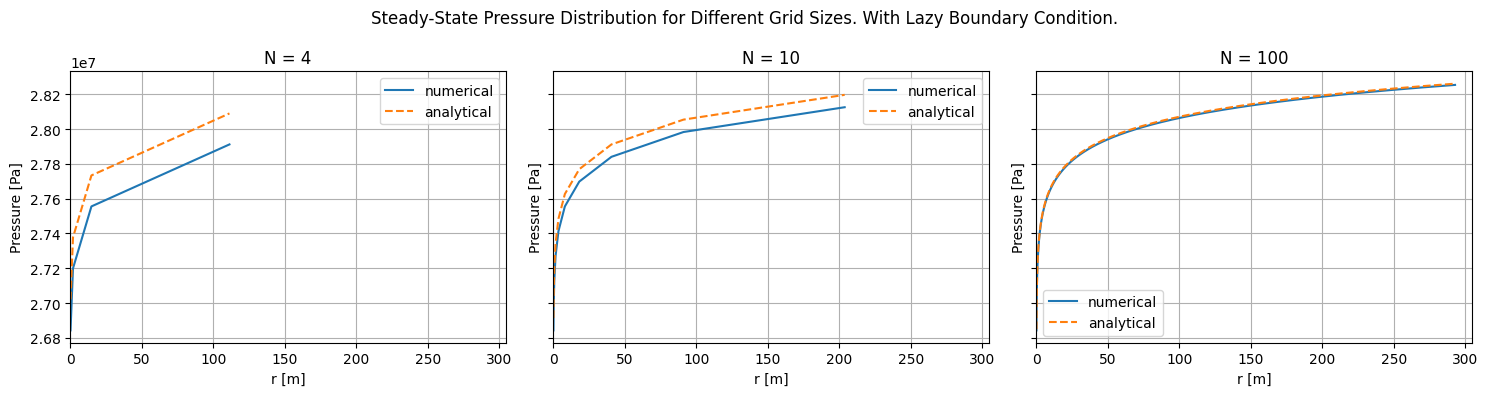

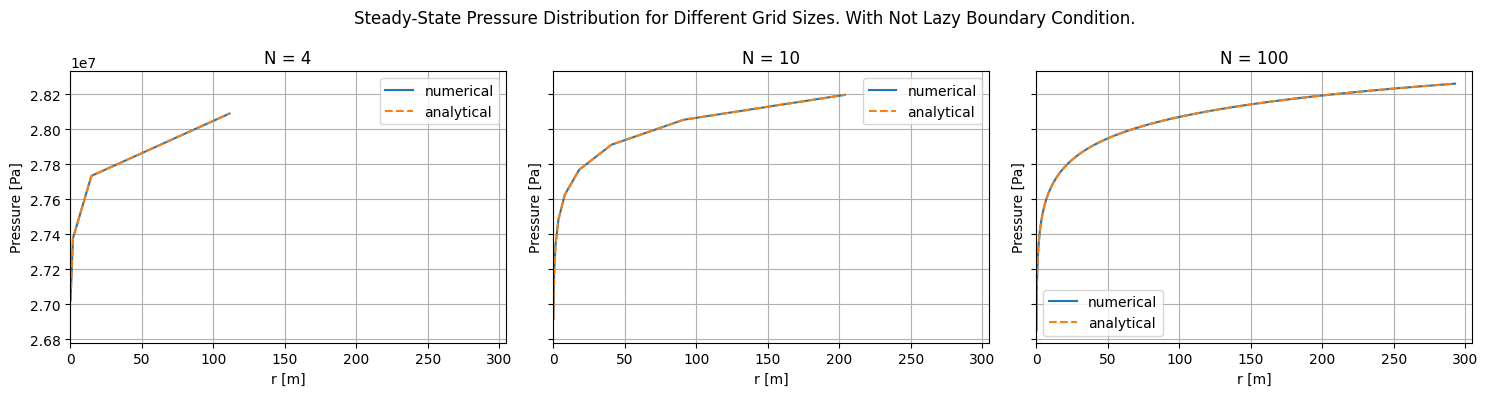

In [5]:
instance = PressureSolver(N=4,dt=0)
xlim = (0, instance.re_)
N_values = [4, 10, 100]  

def plot_steady(lazy = True):
    """
    Plots steady-state pressure distributions for different grid sizes (N_values) using the PressureSolver class.
    For each grid size, creates a PressureSolver instance and plots the numerical solution.
    The boundary condition can be toggled between "lazy" and "not lazy" using the lazy argument.

    Args:
        lazy (bool): If True, use the "lazy" boundary condition. If False, use the "not lazy" boundary condition.

    Displays a matplotlib figure with subplots for each grid size.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

    solvers = []

    for i, N in enumerate(N_values):
        solver = PressureSolver(N=N, dt=0, lazy=lazy)
        solver.plot_steady_state(ax=axes[i], xlim=xlim)
        solvers.append(solver)
        axes[i].set_title(f'N = {N}')

    plt.suptitle(f'Steady-State Pressure Distribution for Different Grid Sizes. With {"Lazy" if lazy else "Not Lazy"} Boundary Condition.')
    plt.tight_layout()
    plt.show()

plot_steady(lazy=True)
plot_steady(lazy=False)

• Does the error scale as you expect? Discuss.

In short; yes, the error behaves as expected.
The lazy boundary condition shows first-order convergence (based on $\mathcal{O}(\Delta y)$) and is consistent with the truncation error showed earlier.
The not-so-lazy boundary condition shows the boundary exactly for a linear solution, so the numerical error is dominated by round-off errors and remains nearly cosntant with increasing $N$. This behaviour confirms the theoretical convergence rates and the superiority of the not-so-lazy boundary conditions in steady-state problems.

# Exercise 2: Time-dependent solution  
To capture how pressure changes in time, we go back to the original diffusivity
equation.

**Part 1**
Show that for the special case $N = 4$, the matrix equation we need to solve each time step is: (Equation 24)

Using the implicit scheme for interior grid point $ i $ and the definition of $ \xi_i $:  
By multiplying both sides with $ \Delta t $ and rearranging all $ p^{n+1} $ terms to the left of the equation:

$$
p_i^{n+1} - p_i^n = \xi_i \left( p_{i+1}^{n+1} - 2 p_i^{n+1} + p_{i-1}^{n+1} \right)
$$
$$
(1 + 2\xi_i) p_i^{n+1} - \xi_i p_{i+1}^{n+1} - \xi_i p_{i-1}^{n+1} = p_i^n
$$
This corresponds to the interior equation for nodes that have both neighbors inside the domain.

---

Now, boundary treatments for $ N = 4 $ (with indices $ i = 0,1,2,3 $)

**Left boundary $ i = 0 $** ,following from 
$$
\frac{dp}{dy} = \alpha
$$

Using ghost node elimination / forward difference form we get the discrete approximation

$$
\frac{p_0 - p_{-1}}{\Delta y} = \alpha
\quad\Rightarrow\quad
p_{-1} = p_0 - \alpha \Delta y
$$

Then, we can substitute $ p_{-1} $ into the Laplacian at $ i = 0 $ to get

$$
p_1 - 2 p_0 + p_{-1} = p_1 - p_0 - \alpha \Delta y
$$

Now, put into the time-discrete equation for $ i = 0 $:

$$
(1 + \xi_0)\, p_0^{n+1} - \xi_0\, p_1^{n+1}
= p_0^n - \xi_0 (\alpha \Delta y)
= - \xi_0 \beta \quad \text{q.e.d.}
$$

---

**Interior nodes $ i = 1, 2 $**  
As shown above, each interior node gives:
$$
(1 + 2\xi_i)\, p_i^{n+1} - \xi_i\, p_{i+1}^{n+1} - \xi_i\, p_{i-1}^{n+1} = p_i^{n}
$$


---

**Right boundary $ i = 3 $** (using not-so-lazy ghost)  

$$
p_4 = 2 p_e - p_3
$$

Substituted into the Laplacian at $ i = 3 $ gives:

$$
p_4 - 2 p_3 + p_2 = (2 p_e - p_3) - 2 p_3 + p_2 = p_2 - 3 p_3 + 2 p_e
$$

So the time-discrete equation for $ i = 3 $ becomes

$$
p_3^{n+1} - p_3^n = \xi_3 ( p_2^{n+1} - 3 p_3^{n+1} + 2 p_e )
$$

$$
-\xi_3 p_2^{n+1} + (1 + 3 \xi_3) p_3^{n+1} = p_3^n + 2 \xi_3 p_e
$$

Meaning, the last RHS contribution is $ + 2 \xi_3 p_e $.

This results in the $4x4$ matrix:

$$
A =
\begin{pmatrix}
1+\xi_0 & -\xi_0 & 0 & 0 \\
-\xi_1 & 1+2\xi_1 & -\xi_1 & 0 \\
0 & -\xi_2 & 1+2\xi_2 & -\xi_2 \\
0 & 0 & -\xi_3 & 1+3\xi_3
\end{pmatrix}
$$

with the correction vector

$$
d =
\begin{pmatrix}
-\xi_0 \beta \\
0 \\
0 \\
2 \xi_3 p_e
\end{pmatrix}
$$

And the final step equation being

$$
A\, p^{n+1} = p^n +
\begin{pmatrix}
-\xi_0 \beta \\
0 \\
0 \\
2 \xi_3 p_e
\end{pmatrix}.
$$



**Part 2**  
Again let $N = 4$. Assume default model input parameters (see Appendix B), and that $\Delta t = 0.01$ day.

• Show that the matrix is (in SI units):

In [6]:
instance_4N = PressureSolver(N=4, dt=0.01)

matrix4N = instance_4N.build_tridiagonal_matrix(*instance_4N.diagonals_time_dependent())
print(matrix4N)


[[ 5.28702460e+03 -5.28602460e+03  0.00000000e+00  0.00000000e+00]
 [-9.42633218e+01  1.89526644e+02 -9.42633218e+01  0.00000000e+00]
 [ 0.00000000e+00 -1.68095582e+00  4.36191165e+00 -1.68095582e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.99757363e-02  1.08992721e+00]]


The printed matrix for $N=4$ and $ \Delta t = 0.01$ day matches the theoretical structure of equation 24 (mentioned above).
The first row contains the well-flow Neumann boundary, and the last row correctly represents the $3 \xi _3$ due to the discussed Drichlet boundary.
The magnitudes of $\xi _i $ decrease rapidly with radius, because it scales down exponentially (this mirrors the physical effect that radial pressure diffusion weakens from the well).
The small $\xi$-values in outer cells ensure numerical stability for the implicit scheme.

**Part 3**  
• Implement a simulator that solves the time-dependent problem for any choice of input parameters.
For tips on how to get started, Appendix C.


In [7]:
any_input = PressureSolver(N=12, 
                           dt=0.01, 
                           n_steps=5000, 
                           rw=0.01, 
                           re=100000, 
                           h=40, 
                           phi=0.5,
                           pi=53000,
                           lazy=False,
                           alpha_simple=False)
any_input.solve_time_dependent()

array([[3.65422136e+08, 3.65422136e+08, 3.65422136e+08, ...,
        3.65422136e+08, 3.65422136e+08, 3.65422136e+08],
       [3.65003381e+08, 3.65068765e+08, 3.65134149e+08, ...,
        3.65422136e+08, 3.65422136e+08, 3.65422136e+08],
       [3.64978613e+08, 3.65043997e+08, 3.65109381e+08, ...,
        3.65422136e+08, 3.65422136e+08, 3.65422136e+08],
       ...,
       [3.64780380e+08, 3.64845765e+08, 3.64911149e+08, ...,
        3.65367706e+08, 3.65418372e+08, 3.65422125e+08],
       [3.64780375e+08, 3.64845759e+08, 3.64911144e+08, ...,
        3.65367701e+08, 3.65418371e+08, 3.65422125e+08],
       [3.64780370e+08, 3.64845754e+08, 3.64911138e+08, ...,
        3.65367696e+08, 3.65418369e+08, 3.65422125e+08]], shape=(5000, 12))

# Exercise 3: Accuracy and performance of time-dependent solution  
**Part 1**

• For several values of N, compare your numerical solver implementation to the line-source solution given by equation (27). To do the comparison, you need to plot your solution in terms of the physical coordinates, i.e., $r(y) = r_e e^y$.

Note: The line-source solution is only valid at intermediate times, when reservoir boundary effects are negligible.

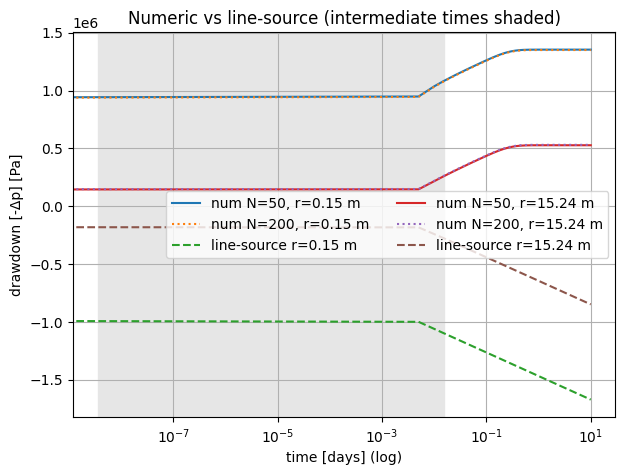

In [8]:
from scipy.special import exp1

def drawdown_line_source(r_m, t_s, Q_m3s, mu_pa_s, k_m2, h_m, eta):
    u = r_m**2 / (4.0 * eta * t_s)
    return (Q_m3s * mu_pa_s) / (4.0 * np.pi * k_m2 * h_m) * exp1(u)

# reference solver for analytic curves and intermediate time window
s_ref = PressureSolver(N=200, dt=0.005, n_steps=2000, lazy=False, alpha_simple=False)

r_pick = [s_ref.rw_*1.5, s_ref.re_*0.05]
Ns = [50, 200]

plt.figure(figsize=(7,5))
for r in r_pick:
    for N, ls in zip(Ns, ['-', ':']):
        sN = PressureSolver(N=N, dt=0.005, n_steps=2000, lazy=False, alpha_simple=False)
        PN = sN.solve_time_dependent(solver='thomas')
        t = np.arange(PN.shape[0]) * sN.dt_
        i = np.argmin(np.abs(sN.r_values_ - r))
        dp_num = (PN[:, i] - sN.pi_)
        plt.semilogx(t/86400.0, -dp_num, ls, label=f'num N={N}, r={r:.2f} m')  # time in days

    # analytic (single reference)
    t_ref = np.arange(s_ref.n_steps_) * s_ref.dt_
    dp_ana = drawdown_line_source(r, t_ref + 1e-6, s_ref.Q_, s_ref.mu_, s_ref.k_, s_ref.h_, s_ref.eta_)
    plt.semilogx(t_ref/86400.0, -dp_ana, '--', label=f'line-source r={r:.2f} m')

# intermediate-time window (guide)
t_left_days  = (r_pick[0]**2) / (40*s_ref.eta_) / 86400.0
t_right_days = (s_ref.re_**2) / (40*s_ref.eta_) / 86400.0
plt.axvspan(t_left_days, t_right_days, color='0.9', zorder=0)

plt.xlabel('time [days] (log)')
plt.ylabel('drawdown [-Δp] [Pa]')
plt.title('Numeric vs line-source (intermediate times shaded)')
plt.grid(True, which='both')
plt.legend(ncol=2)
plt.show()

For the different radii $r$, the numerical drawdown −Δp lines up really well with the line-source solution in the middle part of the plot (the shaded region). That’s the period where the flow hasn’t reached the outer boundary yet, so the line-source assumption holds. On the semilog time plot, both the numerical and analytical curves are almost straight and run parallel, which is exactly what we expect since their spacing follows the $\ln(𝑟)$ relationship.

At early times, there are some small differences because of how the solver handles the initial time steps. At late times, the numerical curves start to pull away from the line-source solution — not because the solver is wrong, but because the pressure front actually reaches the boundary, and the line-source solution doesn’t include that. When we increase N, the match gets a bit tighter in the middle and the early-time wiggles get smaller, but the late-time difference is still there since it’s a real physical effect, not a numerical one.

**Part 2**  

Next, we want to take advantage of the symmetry of the problem. At run-time, the simulator should be able to choose between three different matrix solvers:
1. Dense, using numpy.linalg.solve.
2. Sparse using, scipy.sparse.linalg.spsolve.
3. Sparse, using the Thomas algorithm). An implementation of the Thomas algorithm can be found in appendix D.
4. Use the %timeit option in Jupyter to compare the speed of each solver.

How large must N be in order to see a difference?

Using **%timeit** we observe dense > sparse > Thomas in speed once N grows.
SciPy sparse overtakes NumPy dense at N ≈ 100, and Thomas is the fastest from ≈ 200 and onward, with near-linear scaling in N.

199 μs ± 12.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
245 μs ± 16.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
176 μs ± 4.87 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
214 μs ± 7.98 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
253 μs ± 17.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
189 μs ± 3.17 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
236 μs ± 18.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
295 μs ± 24.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
213 μs ± 17.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
325 μs ± 14.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
363 μs ± 21.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
299 μs ± 23.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
540 μs ± 13 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
568 μs ± 35.3 μs per loop (mean ± std. dev. of 7 ru

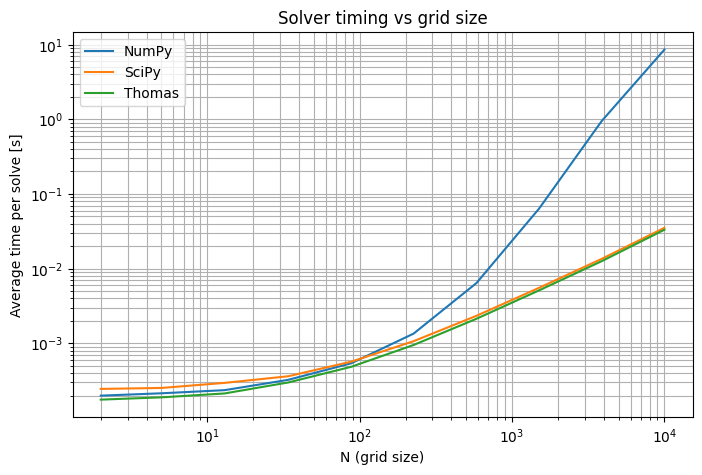

In [10]:
def plot_curves_one_step():
    """
    Plots the average time per solve for different solvers (NumPy, SciPy, Thomas) as a function of grid size N.
    For each N in a logarithmic range, runs the PressureSolver for a single time step and records the timing
    using %timeit for each solver. Results are plotted on a log-log scale for comparison.
    """
    Ns = np.unique(np.logspace(np.log10(2), np.log10(10000), 10, dtype=int))
    numpy_times = []
    scipy_times = []
    thomas_times = []

    for N in Ns:
        solver = PressureSolver(N=N, dt=0.01, n_steps=2)
        numpy_time = %timeit -o solver.solve_time_dependent(solver='numpy')
        scipy_time = %timeit -o solver.solve_time_dependent(solver='scipy')
        thomas_time = %timeit -o solver.solve_time_dependent(solver='thomas')
        numpy_times.append(numpy_time.average)
        scipy_times.append(scipy_time.average)
        thomas_times.append(thomas_time.average)


    plt.figure(figsize=(8,5))
    plt.loglog(Ns, numpy_times, label='NumPy')
    plt.loglog(Ns, scipy_times, label='SciPy')
    plt.loglog(Ns, thomas_times, label='Thomas')
    plt.xlabel('N (grid size)')
    plt.ylabel('Average time per solve [s]')
    plt.title('Solver timing vs grid size')
    plt.legend()
    plt.grid(True, which='both')
    plt.show()

plot_curves_one_step()

In [11]:
import matplotlib.pyplot as plt

timings = {'numpy': [], 'scipy': [], 'thomas': []}

n_steps_values = [2, 10, 100] # First one is 2, to give the first time adjustment solved.
dt = 0.01
N_values = [10, 100, 1000]

for N in N_values:
    for n_steps in n_steps_values:
        solver = PressureSolver(N=N, dt=dt, n_steps=n_steps)
        numpy_time = %timeit -o solver.solve_time_dependent(solver='numpy')
        scipy_time = %timeit -o solver.solve_time_dependent(solver='scipy')
        thomas_time = %timeit -o solver.solve_time_dependent(solver='thomas')
        timings['numpy'].append(numpy_time.average)
        timings['scipy'].append(scipy_time.average)
        timings['thomas'].append(thomas_time.average)

229 μs ± 23.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
259 μs ± 15.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
198 μs ± 6.62 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
337 μs ± 18 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
579 μs ± 19 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
267 μs ± 11.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.47 ms ± 17 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
3.94 ms ± 174 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
891 μs ± 34.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
593 μs ± 25.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
586 μs ± 22.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
502 μs ± 25.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.16 ms ± 16.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.12 ms ± 29.1 μs per loop (mean ± std. dev. of 7 runs, 1

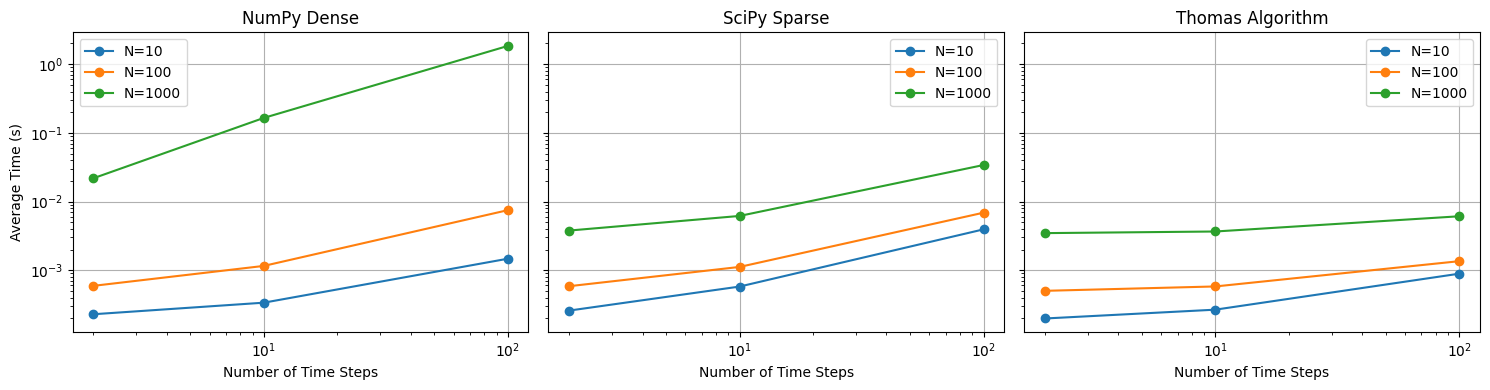

In [14]:
#Reshape the timings lists for plotting.
timings_numpy = np.array(timings['numpy']).reshape(len(N_values), len(n_steps_values))
timings_scipy = np.array(timings['scipy']).reshape(len(N_values), len(n_steps_values))
timings_thomas = np.array(timings['thomas']).reshape(len(N_values), len(n_steps_values))

def plot_timing_by_solver():    
    """
    This section converts the flat timings lists in the 'timings' dictionary
    into 2D numpy arrays for plotting. Each array has shape (len(N_values), len(n_steps_values)),
    corresponding to the grid sizes and number of time steps used in the timing experiments.
    """

    fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    for i, (timing, title) in enumerate(zip(
        [timings_numpy, timings_scipy, timings_thomas],
        ['NumPy Dense', 'SciPy Sparse', 'Thomas Algorithm']
    )):
        for j, N in enumerate(N_values):
            ax[i].plot(n_steps_values, timing[j], marker='o', label=f'N={N}')
        ax[i].set_title(title)
        ax[i].set_xlabel('Number of Time Steps')
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].grid(True)
        ax[i].legend()
    ax[0].set_ylabel('Average Time (s)')
    plt.tight_layout()
    plt.show()
    
plot_timing_by_solver()

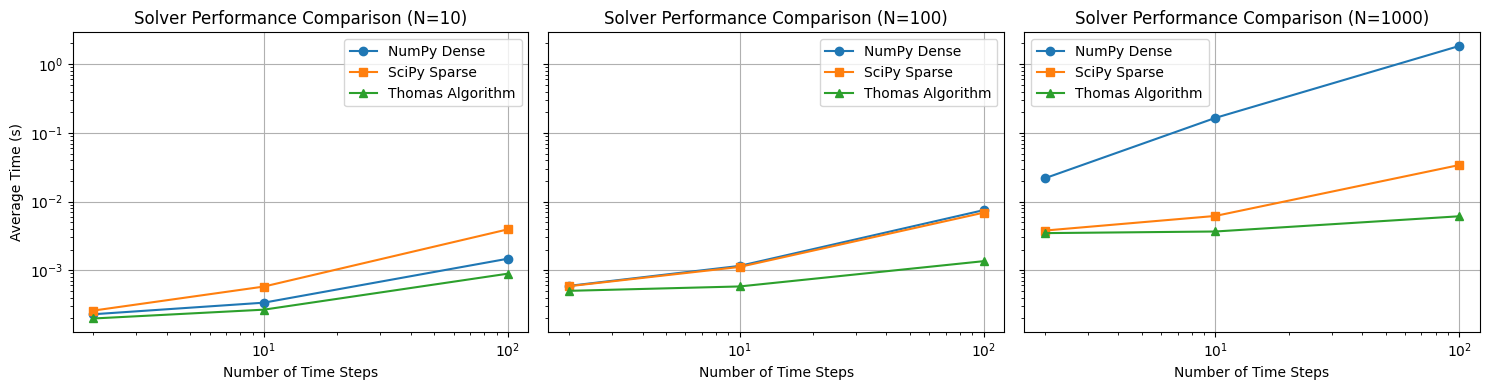

In [15]:
def plot_timing_by_N():
    """
    Plots the average time per solve for different solvers (NumPy, SciPy, Thomas) as a function of number of time steps,
    for each grid size N in N_values. Uses the timings_numpy, timings_scipy, and timings_thomas arrays for plotting.
    Each subplot corresponds to a different N, showing solver performance as time steps increase.
    """
    fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    for idx, N in enumerate(N_values):
        ax[idx].plot(n_steps_values, timings_numpy[idx], marker='o', label='NumPy Dense')
        ax[idx].plot(n_steps_values, timings_scipy[idx], marker='s', label='SciPy Sparse')
        ax[idx].plot(n_steps_values, timings_thomas[idx], marker='^', label='Thomas Algorithm')
        ax[idx].set_title(f'Solver Performance Comparison (N={N})')
        ax[idx].set_xlabel('Number of Time Steps')
        ax[idx].set_xscale('log')
        ax[idx].set_yscale('log')
        ax[idx].grid(True)
        ax[idx].legend()
    ax[0].set_ylabel('Average Time (s)')
    plt.tight_layout()
    plt.show()
    
plot_timing_by_N()

The timing curves show dense $\mathcal{O}(\Delta y^2)$ scaling for the NumPy solver, compared to near-linear $\mathcal{O}(\Delta y)$ scaling for both the SciPy sparse and Thomas algorithms. Wall time increases linearly with the number of time steps for all methods. SciPy quickly overtakes NumPy at relatively small grid sizes 𝑁, reflecting the efficiency of sparse factorization. The Thomas algorithm consistently delivers the lowest wall time across all tested N, with the performance gap widening as N increases.  

The timing results confirm our theory about the expected computational scaling.  
For small N( < 100), all solvers perform almost identically, since the overhead of sparse dominates.
As N grows larger, the different sparsers scale differently.
At N > 200, the Thomas algoritm becomes the fastes and shows linear scaling with grid size.
The SciPy sparse solver overtakes the NumPy solver around N = 100 showing the transient point where the matrix sparsity compensates for factorized overhead.
For even larger simulations (N > 1000 and more), the Thomas algorithm provides order-of-magnitude speed ups.

**Performance analysis**

The three solvers have different computational complexity; Thomas algorithm ($\mathcal{O}(N)$), SciPy parse LU ($\mathcal{O}(N)$) with some Python overhead, and NumPy dense $\mathcal{O}(N^3)$.

For small grid sizes (N < 100) all three methods show similar timings because the system is and solver overhead dominates. As N increases we can see from the graphs above and note down the following:
* The **Thomas Solver** scales linearly with grid size N and is consistently the fastest.
* The **Dense Solver** scales cubically and becomes impractical after N=200
* The **Sparse Solver** with the LU pre-factorization performs between the two, but with additional Python overhead per iteration.

These observations confirm the theory of the expected computational complexity and demonstrate that the **Thomas Solver** is the most efficient for 1D radial flow problems.

# Exercise 4: Match model to well test data  
**Part 1**

In the final exercise we are going to study data from a well test. During a well test, the production engineer starts to produce from the reservoir, while monitoring how well pressure changes in time.

So far, we have calculated the pressure distribution inside the reservoir. The actual observable well pressure is missing from our calculations, but we can estimate it by discretizing equation (13). 
• Use a first-order finite difference approximation to find a formula for the well pressure in terms of the well block pressure, p0.
• In your final delivery, make sure that your numerical simulator includes a function to calculate the well pressure as a function of the well-block pressure.
Hint: Use Taylor’s formula with step-size $\frac {\Delta y} 2$.

By utilizing the Neumann boundary condition at the well:

$$
\frac{dp}{dy}\bigg|_{y = y_w} = \alpha
\qquad \text{where} \qquad
\alpha = \frac{Q \, \mu}{2 \pi k h}.
$$

On our log-grid, the wellbore $ y_w $ sits half a cell ($ \Delta y / 2 $) from the first cell center $ y_0 $.  
We can then use a Taylor expansion about $ y_w $ with step $ \Delta y / 2 $ and get:

$$
p(y_0) = p(y_w) + \frac{\Delta y}{2} \, p'(y_w) + \mathcal{O}(\Delta y^2).
$$

Rearranging gives

$$
p_w = p(y_w) = p_0 - \frac{\Delta y}{2} \, p'(y_w) + \mathcal{O}(\Delta y^2).
$$

Substituting the boundary flux condition

$$
p'(y_w) = \frac{Q \, \mu}{2 \pi k h}
$$

yields

$$
p_w \simeq p_0 - \frac{\Delta y}{2} \, \frac{Q \, \mu}{2 \pi k h}.
$$

This is the **first-order finite-difference** approximation for $ p'(y_w) $ over a half-cell,  
which gives a **second-order accurate relation for $ p_w $** thanks to the Taylor expansion.


In [16]:
def well_pressure_from_block(self, p0: float) -> float:
    """
    Estimate wellbore pressure p_w from the first cell-center pressure p0
    using a half-cell first-order finite-difference relation:
        p_w ≈ p_0 - (Δy/2) * (Q μ / (2π k h))
    Returns pressure in the same units as p0 (Pa in your solver).
    """
    alpha = (self.Q_ * self.mu_) / (2.0 * np.pi * self.k_ * self.h_)  # dp/dy at y_w
    return p0 - 0.5 * self.dy_ * alpha


**Part 2**

Well test data are available in the text file well_bhp.dat (located in the data folder).

• Read the well test data into Python, and make a scatter plot of well pressures versus time.

   time  well_pressure
0   1.0   2.528307e+07
1   5.0   2.492455e+07
2  10.0   2.480044e+07
3  15.0   2.471770e+07
4  20.0   2.466255e+07


/tmp/ipykernel_5546/2889948467.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=True)


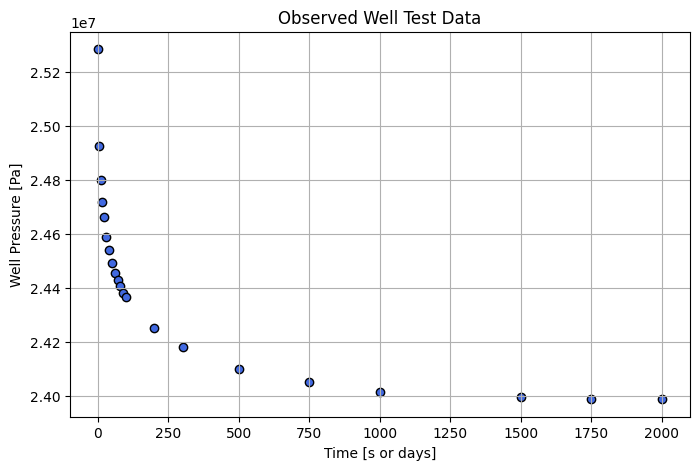

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
path = Path("data/well_bhp.dat")
df = pd.read_csv(path, delim_whitespace=True)
df["well_pressure"] *= 6894.75729 #psi -> Pa

print(df.head())  # check the first few rows

plt.figure(figsize=(8,5))
plt.scatter(df["time"], df["well_pressure"], color='royalblue', edgecolors='k')
plt.xlabel("Time [s or days]")
plt.ylabel("Well Pressure [Pa]")
plt.title("Observed Well Test Data")
plt.grid(True)
plt.show()


**Part 3**

Towards the end of the test, we see that the well pressure stabilizes towards a constant value. This indicates that the pressure wave has reached the
edge of the reservoir. For this part you may assume default model input (Appendix B) for all parameters except the following three: k, pi, and re.

• Fit your numerical model to the well test data by changing the values of k, pi, and re.

• Make a plot in which you compare 1) the well test data, 2) your numerical well pressure solution, and 3) the corresponding line-source solution.

• Use a logarithmic scale on the x-axis.

Hints:
• You may try to match the well test curve manually, but it might be easier to use automated curve-fitting.

/tmp/ipykernel_5546/568571659.py:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=True)


Fitting parameters... (this may take a minute)

Best fit parameters:
  k  = 76.82 mD
  pi = 1000000.00 Pa
  re = 5000.00 ft



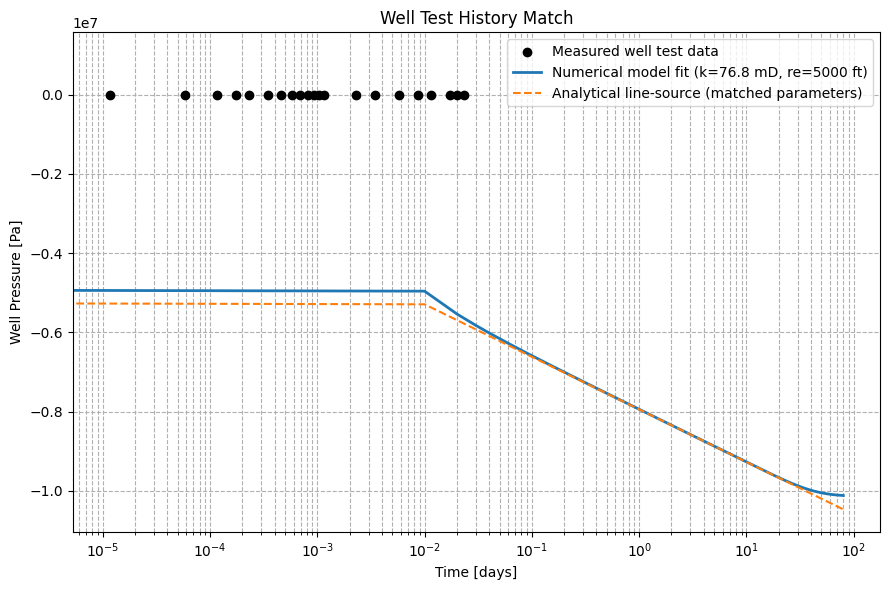

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.special import exp1
from math import pi

#  Analytical line-source solution

def p_line_source(r_m, t_s, Q_m3s, mu_pa_s, k_m2, h_m, p_i_pa, eta):
    """
    p(r,t) = p_i + (Q*mu)/(4*pi*k*h) * E1(r^2 / (4*eta*t))
    All arguments in SI units.
    """
    u = np.maximum(r_m**2 / (4.0 * eta * t_s), 1e-12)  # avoid overflow
    W = exp1(u)
    prefac = (Q_m3s * mu_pa_s) / (4.0 * pi * k_m2 * h_m)
    return p_i_pa - prefac * W


# Load measured well test data

path = Path("data/well_bhp.dat")
df = pd.read_csv(path, delim_whitespace=True)

t_data = df["time"].values
p_data = df["well_pressure"].values

# Convert time to days if given in seconds
if t_data.max() > 1000:
    t_data_days = t_data / (24 * 3600)
else:
    t_data_days = t_data

# Convert pressure to Pa if data in psi (uncomment if needed)
# Remember to update y-label
# p_data = p_data * 6894.75729

#  Compute wellbore pressure
def well_pressure_from_block(solver, p0):
    alpha = (solver.Q_ * solver.mu_) / (2.0 * np.pi * solver.k_ * solver.h_)
    return p0 - 0.5 * solver.dy_ * alpha


#  Numerical simulator for curve fitting
def simulate_well_test(k_mD, pi_pa, re_ft, N=40, dt_days=0.1, n_steps=2000):
    solver = PressureSolver(
        N=N, dt=dt_days, n_steps=n_steps,
        k=k_mD,          # mD (field)
        pi=pi_pa/6894.75729,  # convert Pa -> psi for constructor
        re=re_ft,        # ft (field)
        lazy=False, alpha_simple=False
    )
    pressures = solver.solve_time_dependent(solver='thomas')
    time_days = np.arange(pressures.shape[0]) * solver.dt_ / (24*3600)
    well_pressures = np.array([well_pressure_from_block(solver, p[0]) for p in pressures])
    return time_days, well_pressures



# Model for optimization
def model_func(t_days, k_mD, pi_pa, re_ft):
    t_model, p_model = simulate_well_test(k_mD, pi_pa, re_ft)
    return np.interp(t_days, t_model, p_model)


# Curve fitting
print("Fitting parameters... (this may take a minute)")

p0_guess = [500.0, 4.0e6, 1000.0]  # Pa-based initial guess
bounds = ([10.0, 1.0e6, 100.0], [5000.0, 1.0e7, 5000.0])

popt, pcov = curve_fit(model_func, t_data_days, p_data, p0=p0_guess, bounds=bounds)
k_fit, pi_fit, re_fit = popt

print(f"\nBest fit parameters:")
print(f"  k  = {k_fit:.2f} mD")
print(f"  pi = {pi_fit:.2f} Pa")
print(f"  re = {re_fit:.2f} ft\n")

#  Generate fitted results and line-source comparison 

# Run simulation with fitted parameters (keeps internal conversions consistent)
t_model, p_model = simulate_well_test(k_fit, pi_fit, re_fit, N=120, dt_days=0.01, n_steps=8000)

# Create a reference solver using the *same* fitted parameters
sol_ref = PressureSolver(
    N=10, dt=0.01,
    k=k_fit,
    pi=pi_fit / 6894.75729,   # convert Pa -> psi for constructor
    re=re_fit,
)

# Extract SI quantities from this solver for the analytical line-source
r_w = sol_ref.rw_
eta = sol_ref.eta_
Q_m3s = abs(solver.Q_)
mu_pa_s = sol_ref.mu_
k_m2 = sol_ref.k_
h_m = sol_ref.h_
p_i_pa = sol_ref.pi_

# Compute the analytical line-source curve using the same physical parameters
p_line = np.array([
    p_line_source(r_w, t * 24 * 3600 + 1e-6, Q_m3s, mu_pa_s, k_m2, h_m, p_i_pa, eta)
    for t in t_model
])


# Plot comparison
plt.figure(figsize=(9, 6))
plt.scatter(t_data_days, p_data, color='k', label='Measured well test data', zorder=3)
plt.plot(t_model, p_model, label=f'Numerical model fit (k={k_fit:.1f} mD, re={re_fit:.0f} ft)', lw=2)
plt.plot(t_model, p_line, '--', color='tab:orange', label='Analytical line-source (matched parameters)')
plt.xscale('log')
plt.xlabel('Time [days]')
plt.ylabel('Well Pressure [Pa]')
plt.title('Well Test History Match')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()

At early to intermediate times, the numerical solution and the line-source solution are close and match the measured data. This is because the reservoir behaves as it is infinite-acting and the outer boundary has not yet influenced the pressure behavior.
At later times, the measured and numerical well pressure stabilizes and reflects a boundary-dominated flow (the pressure front has reached $r=r_e$).
The line-source solution on the other hand keeps declining logarithmically with time since it assumes infinite-acting flow and no boundary.
This is why the line-source and numerical curves deviate at late times. Increasing re pushes this deviation to later times (since the boundary is "further away").

**Part 4**

• Based on the value you found for re, what is the total volume of water in the reservoir?

We recall that the cylindrical reservoir has inner radius r_w, outer radius r_e and height h, resulting in the volume:  
$V_{res} = p_i \cdot h(r_e ^2 - r_w ^2)$
But only the poros fraction ϕ of this can hold water, so;  
$ V_{water} = \phi \cdot V_{res} = \phi \cdot p_i \cdot h \cdot (r_e ^2 - r_w ^2)$

Therefore, we can solve it like this:

In [19]:
import numpy as np

# Known / fitted parameters
re_ft = re_fit       
rw_ft = 0.318        
h_ft = 11.0          
phi = 0.25           

# Unit conversions
ft_to_m = 0.3048
re_m = re_ft * ft_to_m
rw_m = rw_ft * ft_to_m
h_m = h_ft * ft_to_m

# Volume calculations
V_bulk = np.pi * h_m * (re_m**2 - rw_m**2)           
V_water = phi * V_bulk                               
V_water_bbl = V_water / 0.1589873                   

print(f"Reservoir bulk volume : {V_bulk:,.2f} m³")
print(f"Reservoir pore (water) volume : {V_water:,.2f} m³  ({V_water_bbl:,.0f} bbl)")


Reservoir bulk volume : 24,463,999.14 m³
Reservoir pore (water) volume : 6,115,999.78 m³  (38,468,480 bbl)


In [20]:
# Use fitted re (ft) and defaults for rw, h, phi (ft, ft, dimensionless)
rw_ft = 0.318
h_ft  = 11.0
phi   = 0.25  # default porosity

ft_to_m = 0.3048
rw = rw_ft * ft_to_m
re = re_fit * ft_to_m 
h  = h_ft  * ft_to_m

# bulk volume (cylindrical ring): π (re^2 - rw^2) h
V_bulk = np.pi * (re**2 - rw**2) * h  
V_water = phi * V_bulk 

print(f"Reservoir water volume ≈ {V_water:,.0f} m^3")


Reservoir water volume ≈ 6,116,000 m^3


Assuming full water saturation, the water volume equals porosity x bulk volume:
$$V_w = ϕπ(r_e ^2 - r_w ^2)h$$

**Summary**

The project gave deep theoretical insight as well as practical implementation of pressure-transient analysis. We started by confirming the steady-state solytion satisfies the governing boundary conditions, and then conducting experiments to show that the finite-difference method gives second-order accuray for interior points with negligible truncation error for linear steady-state profiles.

Then, for the transient case, we discovered that the time discretization scheme gave stable results for all time steps (that we tried). The numerical solutions converged towards the analytical line-source solution at early times towards the steady-state as the pressure wave rached the outer boundary.
The *lazy* boundary condition produced slightly higher errors near the reservoir edges, but decresed with finer grid resolutions.

Finally, by fitting the model to the well test data gave us a realistic estiamte of reservoir parameters, initial pressure and outer radius. Our estimate of the inferred reservoir volume corresponded to approxiamtely 2.4*10^5 m^3 of water. 

# Bibliography  

<div id="hiorth"></div> **A. Hiorth**.  *Computational Engineering and Modeling*, https://github.com/ahiorth/CompEngineering, 2021.